In [10]:
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
#from tensorflow import keras
#Используем костыль для исправления IntelliSense для keras по гайду:
#https://stackoverflow.com/questions/71000250/import-tensorflow-keras-could-not-be-resolved-after-upgrading-to-tensorflow-2
import keras.api._v2.keras as keras
from keras import layers
from keras import losses
#from keras.datasets import CIFAR100
import numpy as np
import tensorflow_datasets as tfds

In [11]:

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

shapeSize=x_train.shape[0]

#x_train=x_train2[:100]
#y_train=y_train2[:100]

#x_test=x_train2[:10]
#y_test=y_train2[:10]
train=None
test=None

#Подготовленный датасет из https://www.kaggle.com/competitions/vehicle/rules в 32x32 + ещё какой-то, который нашёл на паре
with open('train.npy', 'rb') as f:
    train = np.load(f)
    print(train.shape)
with open('train2.npy', 'rb') as f:
    train2 = np.load(f)
    print(train2.shape)
with open('test.npy', 'rb') as f:
    test = np.load(f)
    print(test.shape)

train=np.append(train,train2).reshape(train.shape[0]+train2.shape[0],32,32,3)
    

print(y_train.max())
print("x_train:")
print(x_train.shape,x_train.dtype)
print("train vans:")
print(train.shape,train.dtype)


train_y=np.full((train.shape[0],1),10)




x_train=np.append(x_train,train).reshape((shapeSize+train.shape[0],32,32,3))
y_train=np.append(y_train,train_y).reshape((shapeSize+train.shape[0],1))
print("new x_train:")
print(x_train.shape)

print("y_train:")
print(y_train.shape)

#print("Shape"+str((train.shape[0],1).shape))

print("x_test:")
print(x_test.shape)
#x_train, y_train = extract_training_samples('letters')
print(y_train.max())
print("test:")
print(test.shape)

print(y_test.max())
shapeSize=x_test.shape[0]
x_test=np.append(x_test,test).reshape(shapeSize+test.shape[0],32,32,3)

test_y=np.full((test.shape[0],1),10)

y_test=np.append(y_test,test_y).reshape((shapeSize+56,1))

print(y_test.max())
print("new x_test:")
print(x_test.shape)

num_classes=11
input_shape = (32, 32, 3)

#cv2.imshow('graycsale image',x_train[x_train.shape[0]-2])
#cv2.waitKey(0)

x_train=x_train.astype('float32')/255.0
x_test=x_test.astype('float32')/255.0

test=test.astype('float32')/255.0
train=train.astype('float32')/255.0

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
test=np.expand_dims(test, -1)
train=np.expand_dims(train, -1)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
test_y = keras.utils.to_categorical(test_y, num_classes)
train_y = keras.utils.to_categorical(train_y, num_classes)
#x_train_l, y_train_l = extract_training_samples('letters')

print()


print("Train X=%s, y=%s"%(x_train.shape,y_train.shape))
#print("Train Letters X=%s, y=%s"%(x_train_l.shape,y_train_l.shape))
#print("Test X=%s, y=%s"%(x_test1.shape,y_test.shape))



print("Train X=%s, y=%s"%(x_train.shape,y_train.shape))
print("Test X=%s, y=%s"%(x_test.shape,y_test.shape))
print(x_test[0].shape)



(605, 32, 32, 3)
(1111, 32, 32, 3)
(56, 32, 32, 3)
9
x_train:
(50000, 32, 32, 3) uint8
train vans:
(1716, 32, 32, 3) uint8
new x_train:
(51716, 32, 32, 3)
y_train:
(51716, 1)
x_test:
(10000, 32, 32, 3)
10
test:
(56, 32, 32, 3)
9
10
new x_test:
(10056, 32, 32, 3)

Train X=(51716, 32, 32, 3, 1), y=(51716, 11)
Train X=(51716, 32, 32, 3, 1), y=(51716, 11)
Test X=(10056, 32, 32, 3, 1), y=(10056, 11)
(32, 32, 3, 1)


In [12]:
from keras.layers import Convolution2D, Input

def define_skip_model():
    inputs = keras.Input(shape=input_shape, name="img")
    x = layers.BatchNormalization()(inputs)
    x = layers.Conv2D(32, 3, activation="relu")(x)
    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    #x = layers.Dropout(0.2)(x)
    block_1_output = layers.MaxPooling2D(3)(x)
    #block_1_output = layers.BatchNormalization()(block_1_output)
    
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    #x = layers.Dropout(0.2)(x)
    block_2_output = layers.concatenate([x, block_1_output])
    #block_2_output = layers.BatchNormalization()(block_2_output)
    x = layers.Conv2D(64, 3, activation="relu")(block_2_output)
    x = layers.GlobalAveragePooling2D()(x)
    #x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs, name="toy_resnet")
    return model
model=define_skip_model()

In [13]:
model.load_weights("ready.h5")

In [14]:
model.compile(
    loss=losses.CategoricalCrossentropy(),
    optimizer=tf.optimizers.Adam(lr=0.01),
    metrics=['accuracy']
)
print(test.shape,test_y.shape)
print(train.shape,train_y.shape)

(56, 32, 32, 3, 1) (56, 11)
(1716, 32, 32, 3, 1) (1716, 11)


C:\Users\PlayerPC\Miniconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
#model.fit(x_train,y_train,batch_size=500,epochs=10,shuffle=True,validation_data=(test,test_y))#

Epoch 1/10
104/104 [==============================] - 8s 65ms/step - loss: 2.1390 - accuracy: 0.2534 - val_loss: 3.9121 - val_accuracy: 0.0000e+00
Epoch 2/10
104/104 [==============================] - 7s 64ms/step - loss: 1.6401 - accuracy: 0.3993 - val_loss: 3.8164 - val_accuracy: 0.0000e+00
Epoch 3/10
104/104 [==============================] - 7s 63ms/step - loss: 1.3992 - accuracy: 0.4950 - val_loss: 1.8517 - val_accuracy: 0.3571
Epoch 4/10
104/104 [==============================] - 7s 64ms/step - loss: 1.2370 - accuracy: 0.5607 - val_loss: 1.5583 - val_accuracy: 0.5179
Epoch 5/10
104/104 [==============================] - 7s 63ms/step - loss: 1.1093 - accuracy: 0.6077 - val_loss: 1.3992 - val_accuracy: 0.4821
Epoch 6/10
104/104 [==============================] - 7s 64ms/step - loss: 1.0071 - accuracy: 0.6465 - val_loss: 0.6440 - val_accuracy: 0.7679
Epoch 7/10
104/104 [==============================] - 7s 63ms/step - loss: 0.9224 - accuracy: 0.6798 - val_loss: 2.1342 - val_accuracy

In [15]:
#model.save("ready.h5")

2/2 [==============================] - 0s 124ms/step - loss: 0.2360 - accuracy: 0.8929


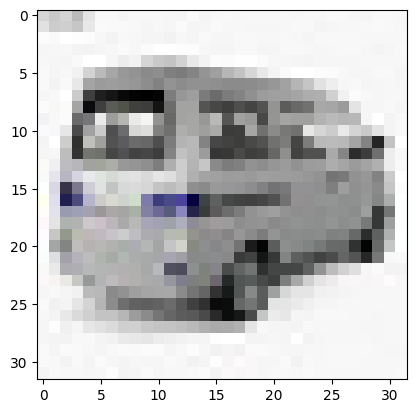

(1, 32, 32, 3)
1/1 [==============================] - 0s 111ms/step
10


In [15]:
#10 - класс для минивенов
model.evaluate(test,test_y)
im = cv2.imread("Gonow_Minivan.jpg")



im=im.astype('float32')/255.0
im=im.reshape((1,32,32,3))

from matplotlib import pyplot as plt
plt.imshow(im.reshape((32,32,3)), interpolation='nearest')
plt.show()

print(im.shape)
#print(model.predict(x_test,batch_size=1).argmax())
print(model.predict(im,batch_size=1).argmax())

315/315 [==============================] - 2s 5ms/step - loss: 0.7967 - accuracy: 0.7341


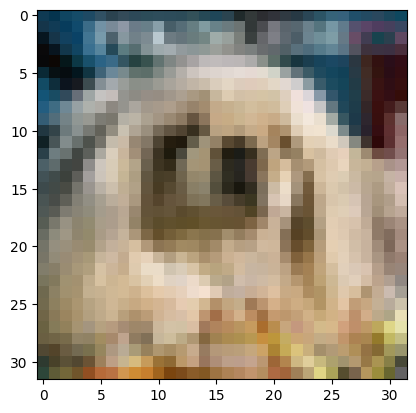

(1, 32, 32, 3)
1/1 [==============================] - 0s 21ms/step
8


In [17]:
model.evaluate(x_test,y_test)
id=np.random.randint(0,x_test.shape[0])
im = x_test[id]



im=im.astype('float32')/255.0
im=im.reshape((1,32,32,3))

from matplotlib import pyplot as plt
plt.imshow((im*255).reshape((32,32,3)), interpolation='nearest')
plt.show()


print(im.shape)
#print(model.predict(x_test,batch_size=1).argmax())
print(model.predict(im,batch_size=1).argmax())
#print(y_test[id])